**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 8**
Regresión Lineal

---

*   NOMBRE: Francisco Javier Cameros Bobadilla, Paola Estrada Warn, Christopher Eduardo Gonzáles Bojorquez, Arantza Maldonado López
*   MATRÍCULA: A01795697, A01795663, A01795482, A01740075

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [2]:
insurance_df = pd.read_csv('insurance.csv')
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# **Parte 1**. EDA

Efectúa una exploración inicial de los datos a través de:

1a) Estadísticas descriptivas para todas las variables del dataframe. 

In [3]:
insurance_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [4]:
insurance_df.describe(include='object').T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


1b) Búsqueda de valores faltantes.

In [5]:
missing_values = insurance_df.isna().mean() *100
missing_values

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

1c) Histrogramas y boxplots para las variables cuantitativas y diagramas de barras con la frecuencia para las variables categóricas. 

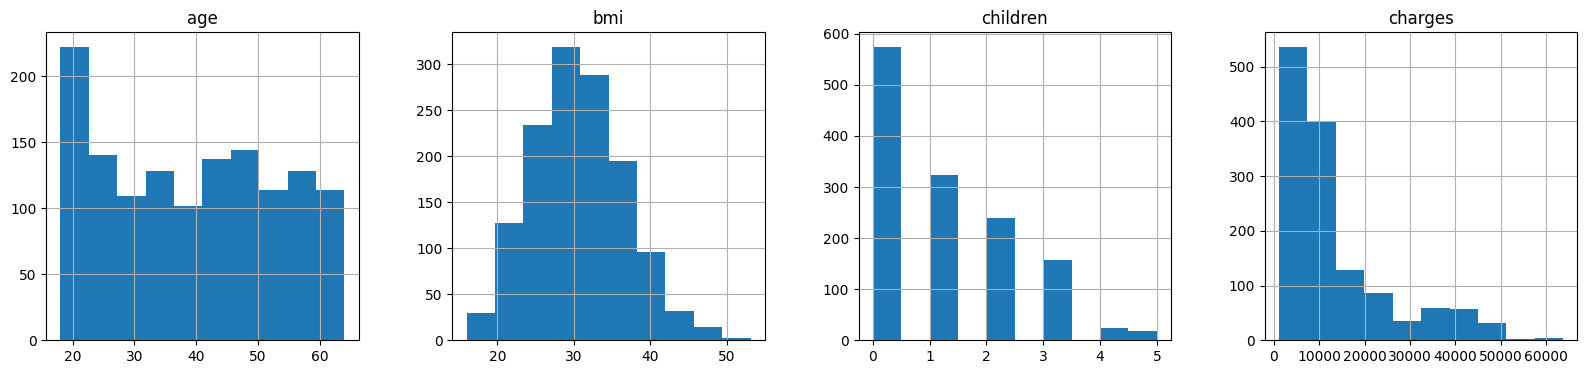

In [6]:
insurance_df.hist(figsize=(25,4), layout=(1,5))
plt.show()

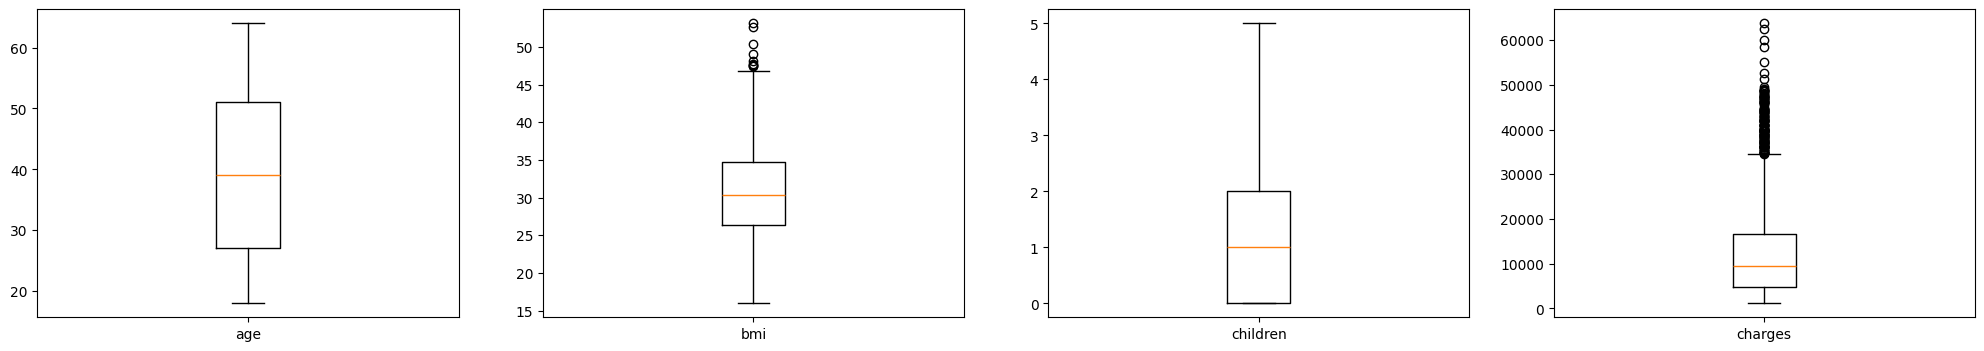

In [7]:
num_cols = insurance_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = insurance_df.select_dtypes(exclude=np.number).columns.tolist()

fig, axes = plt.subplots(1,4, figsize=(25,4))
axes = axes.ravel()
for col, ax in zip(insurance_df[num_cols], axes):
  ax.boxplot(insurance_df[col].dropna(), labels=[f'{col}'])

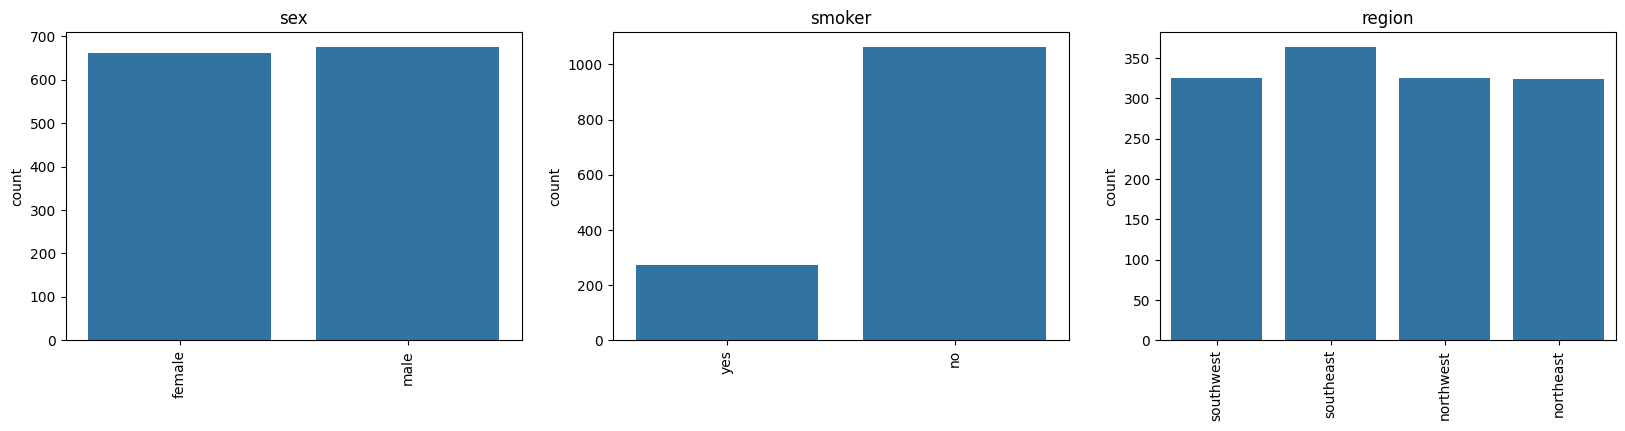

In [8]:
fig, axes = plt.subplots(1,3, figsize=(20,4))
axes = axes.ravel()
for col, ax in zip(insurance_df[cat_cols], axes):
  sns.countplot(x=insurance_df[col], ax=ax)
  ax.set(title=f'{col}', xlabel=None)
  ax.tick_params(axis='x',rotation=90)

Para responder los siguientes cuestionamientos, genera los gráficos indicados:

2a) ¿Hay diferencias significativas de las primas según el sexo? Compara la distribución de la variable `charges` por medio de un boxplot. 

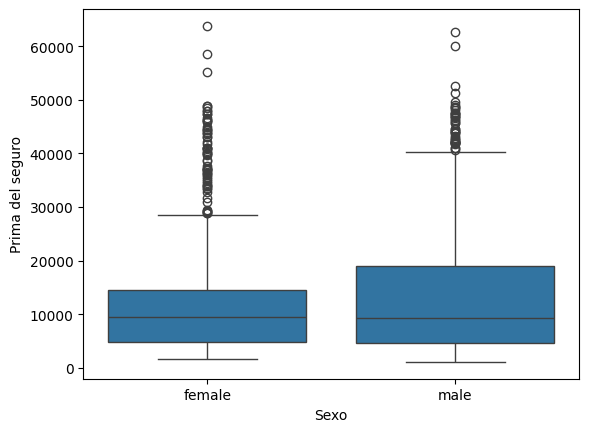

In [9]:
sns.boxplot(data=insurance_df, x="sex", y="charges")
plt.xlabel('Sexo')
plt.ylabel('Prima del seguro')
plt.show()

### Los hombres pagan más de prima de seguro

2b) Crea un diagrama de dispersión de `charges` versus el `bmi` que incorpore la distinción por las categorías `smoker` y `children` (tip: utiliza el parámetro `size`) ¿Hay alguna conclusión importante que se derive del gráfico? 

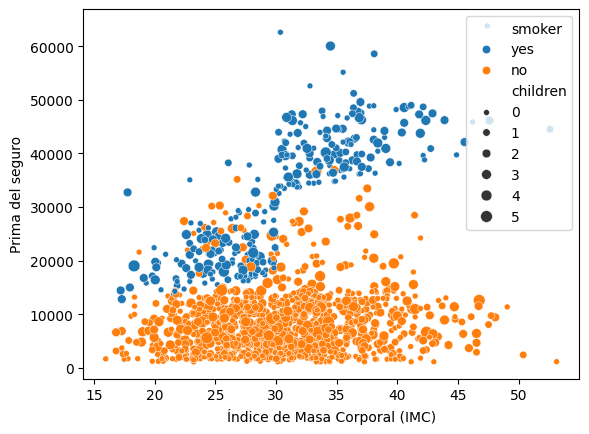

In [10]:
sns.scatterplot(data=insurance_df, x="bmi", y="charges", hue="smoker", size="children")
plt.xlabel('Índice de Masa Corporal (IMC)')
plt.ylabel('Prima del seguro')
plt.show()

### los fumadores con BMI alto pagan más de prima de seguro

2c) Elabora un mapa de calor que muestre la correlación de las variables numéricas. 

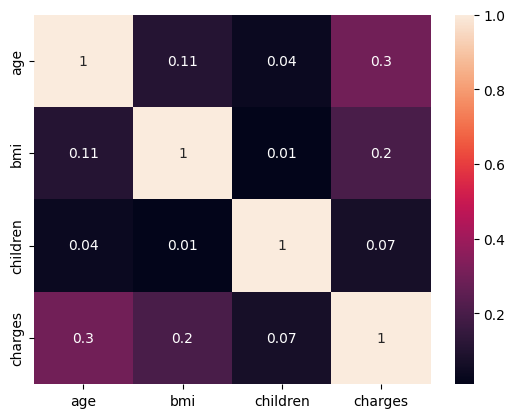

In [11]:
sns.heatmap(round(insurance_df.corr(numeric_only=True),2), annot=True)
plt.show()

Obtén un dataframe con las observaciones que tengan valores atípicos en `charges`. 

3a) ¿Cuál es el promedio de `age` y de `bmi`? 

In [12]:
for col in num_cols:
  IQR = insurance_df[col].quantile(0.75) - insurance_df[col].quantile(0.25)
  lower_limit = insurance_df[col].quantile(0.25) - (IQR * 1.5)
  upper_limit = insurance_df[col].quantile(0.75) + (IQR * 1.5)
  outliers_df = insurance_df[(insurance_df[col] <= lower_limit) | (insurance_df[col]>= upper_limit)]


age_ave = outliers_df.age.mean()
bmi_ave = outliers_df.bmi.mean()
print("Promedio de Edad:", age_ave)
print("Promedio de BMI:", bmi_ave)

Promedio de Edad: 41.07913669064748
Promedio de BMI: 35.564604316546756


3b) ¿Qué porcentaje de estas observaciones se corresponden a mujeres y a hombres? ¿A fumadores y no fumadores? 

In [13]:
female_percent= outliers_df[outliers_df['sex']=='female'].shape[0]/outliers_df.shape[0] *100
male_percent= outliers_df[outliers_df['sex']=='male'].shape[0]/outliers_df.shape[0]*100
smoker_percent= outliers_df[outliers_df['smoker']=='yes'].shape[0]/outliers_df.shape[0]*100
nonsmoker_percent= outliers_df[outliers_df['smoker']=='no'].shape[0]/outliers_df.shape[0]*100

print("% mujeres: ",female_percent,"% hombres: ",male_percent,"% fumadores: ",smoker_percent,"% no fumadores: ",nonsmoker_percent)

% mujeres:  35.97122302158273 % hombres:  64.02877697841727 % fumadores:  97.84172661870504 % no fumadores:  2.158273381294964


# **Parte 2**. Preprocesamiento

4. Separa las variables del dataframe: en `X` coloca los predictores y en `y` la variable de respuesta o salida (`charges`). 

In [14]:
X = insurance_df.drop('charges', axis=1)
y = insurance_df['charges']
X, y

(      age     sex     bmi  children smoker     region
 0      19  female  27.900         0    yes  southwest
 1      18    male  33.770         1     no  southeast
 2      28    male  33.000         3     no  southeast
 3      33    male  22.705         0     no  northwest
 4      32    male  28.880         0     no  northwest
 ...   ...     ...     ...       ...    ...        ...
 1333   50    male  30.970         3     no  northwest
 1334   18  female  31.920         0     no  northeast
 1335   18  female  36.850         0     no  southeast
 1336   21  female  25.800         0     no  southwest
 1337   61  female  29.070         0    yes  northwest
 
 [1338 rows x 6 columns],
 0       16884.92400
 1        1725.55230
 2        4449.46200
 3       21984.47061
 4        3866.85520
            ...     
 1333    10600.54830
 1334     2205.98080
 1335     1629.83350
 1336     2007.94500
 1337    29141.36030
 Name: charges, Length: 1338, dtype: float64)

5. Divide el conjunto en entrenamiento y prueba (80:20) considerando:


*   El parámetro `random_state` con el valor de 1 para garantizar reproducibilidad.
*   Analiza los diagramas de barras obtenidos en el ejercicio 1c. Con los resultados observados, es conveniente usar la variable `smoker` en la estrategia de estratificación.
*   Como ya tienes separadas en `X` e `y` los predictores y salida, consulta cómo ejecutar la función `train_test_split()` para obtener `Xtrain, Xtest, ytrain, ytest` en una única instrucción. 

In [15]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1, stratify=insurance_df['smoker'])
#X_train, X_test

6. Prepara un transformador, denominado `preprocessing`, para aplicar escalamiento *MinMax* a los predictores numéricos y codificación *one-hot* a los categóricas.

In [16]:
#Preprocessing
preprocessing = ColumnTransformer([
    ('num', MinMaxScaler(), make_column_selector(dtype_include=np.number)),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), make_column_selector(dtype_include=object))])

# **Parte 3**. Entrenando y evaluando el modelo de RL

7. Ejecuta un pipeline con el transformador creado y el algoritmo de regresión lineal para entrenar un modelo denominado `lr_model`. 

Evalúa el modelo en el conjunto de prueba y obtén la raíz del error cuadrático medio (`RMSE`) y la métrica `R` cuadrado ($R^2$). Aunque ésta última la estudiarás a detalle la próxima semana, ahora sólo debes saber que toma valores entre 0 y 1, donde 1 indica un ajuste perfecto y, por tanto, un modelo muy fiable para las previsiones futuras. La función de scikit-learn que determina esta métrica es: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [17]:
from sklearn.metrics import r2_score,mean_squared_error

lr_model=make_pipeline(preprocessing,LinearRegression())
lr_model.fit(Xtrain,ytrain)
predictions= lr_model.predict(Xtest)

print("RMSE: ", mean_squared_error(ytest,predictions,squared=False))
print("R: ",r2_score(ytest,predictions))

RMSE:  5698.759784532357
R:  0.7538547215244324


**Valora el rendimiento del modelo con los siguientes cambios:**


8. Reemplaza los outliers de `charges` con el límite superior (`Q3 + 1.5 * IQR`). Haz el cambio en ambos conjuntos: `ytrain` y `ytest`, previo a la aplicación del mismo pipeline. Guarda el modelo como `lr_model2`. 


In [18]:
# Calcular el IQR
Q1 = insurance_df['charges'].quantile(0.25)
Q3 = insurance_df['charges'].quantile(0.75)
IQR = Q3 - Q1

# Calcular el límite superior
limite_superior = Q3 + 1.5 * IQR

# Reemplazar outliers
insurance_no_df = insurance_df.copy()
insurance_no_df['charges'] = np.where(insurance_df['charges'] > limite_superior, limite_superior, insurance_df['charges'])


#Vuelvo a hacer X,y
X = insurance_no_df.drop('charges', axis=1)
y = insurance_no_df['charges']
X, y

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1, stratify=insurance_no_df['smoker'])
##Xtrain, Xtest


In [19]:
lr_model2 = make_pipeline(preprocessing, LinearRegression())
lr_model2.fit(Xtrain, ytrain)
predictions = lr_model2.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', mean_squared_error(ytest, predictions, squared=False))
print('The R square (R2) is:', r2_score(ytest, predictions))

The Root Mean Square Error (RMSE) is: 4812.061728319821
The R square (R2) is: 0.7637776364359081


9. Prepara otro transformador, denominado `preprocessing2`, para aplicar escalamiento estándar a los predictores numéricos y codificación ordinal a los categóricas. Aplícalo en un nuevo pipeline utilizando nuevamente regresión lineal. Guarda el modelo como `lr_model3`. 

**Nota.** Los cambios se ejecutan de manera consecutiva, por ejemplo: el reemplazo de los outliers también se ejecuta previo al transformador `preprocessing2` y así sucesivamente.

In [20]:
# Cambiamos Standard y Ordinal
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
preprocessing2 = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('cat', OrdinalEncoder(), make_column_selector(dtype_include=object))])

In [21]:
lr_model3 = make_pipeline(preprocessing2, LinearRegression())
lr_model3.fit(Xtrain, ytrain)
predictions = lr_model3.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', mean_squared_error(ytest, predictions, squared=False))
print('The R square (R2) is:', r2_score(ytest, predictions))

The Root Mean Square Error (RMSE) is: 4811.600670456456
The R square (R2) is: 0.7638229005936741


10. Utiliza regresión polinomial para verificar si se produce un mejor ajuste. Intenta con varios grados, aunque debes dejar en el código sólo el de mejor rendimiento. Guarda el modelo como `lr_model4`.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
lr_model4= make_pipeline(preprocessing2,PolynomialFeatures(degree=2,include_bias=False),LinearRegression())
lr_model4.fit(Xtrain,ytrain)
predictions4= lr_model4.predict(Xtest)

print("RMSE: ", mean_squared_error(ytest,predictions4,squared=False))
print("R: ",r2_score(ytest,predictions4))

RMSE:  4285.57031096556
R:  0.8126404302016094


# Conclusiones

Conclusiones

La eliminación de los valores atípicos muestra una mejora significativa en el rendimiento.

Cuando el modelo que utiliza StandardScaler y OrdinalEncoder, el modelp tiene una muy ligera mejora casi imperceptible, sin embargo hay que saber porque ya que las variables no son ordinales.

El mejor modelo es el de Polynomial con grado 2, esto sugiere que existen relaciones no lineales entre las características

| Model Description                        | RMSE           | R²                  |
|------------------------------------------|----------------|---------------------|
| OneHotEncoder + MinMax                   | 5698.76        | 0.75385             |
| OneHotEncoder + MinMax (outliers removed) | 4812.06        | 0.76378             |
| StandardScaler + OrdinalEncoder           | 4811.60        | 0.76382             |
| PolynomialFeatures (degree=2)                | 4285.57       | 0.81264            |
